## Canine GWAS EDA

In [1]:
import hail as hl
import pandas as pd
import numpy as np
import plotnine as pn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import os.path as osp
%run ../../init/benchmark.py

register_timeop_magic(get_ipython(), 'hail')
plink_file_tgt = 'cornell_canine'
data_dir_tgt = osp.expanduser('~/data/gwas/canine-hayward-2016-266k4')
plink_file_ref = 'All_Pure_150k'
data_dir_ref = osp.expanduser('~/data/gwas/canine-parker-2017')
hl.init() 

Running on Apache Spark version 2.4.4
SparkUI available at http://d42c6af5a4e5:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.30-2ae07d872f43
LOGGING: writing to /home/eczech/repos/gwas-analysis/notebooks/tutorial/ext/canine-dryad/hail-20200207-2235-0.2.30-2ae07d872f43.log


## Determine Locus Overlap

Because variant nomenclature is nowhere near as standardized for canines as it is for humans, the variant ids in these datasets are not useful.  In order to merge them, we first have to check how often variant loci intersect instead.

In [7]:
def get_bim(data_dir, data_file):
    return pd.read_csv(osp.join(data_dir, data_file + '.bim'), sep='\s+', header=None, names=['contig', 'snp', 'pos', 'locus', 'alt', 'ref'])

def get_fam(data_dir, data_file):
    return pd.read_csv(osp.join(data_dir, data_file + '.fam'), sep='\s+', header=None, names=['fid', 'iid', 'iid_paternal', 'iid_maternal', 'sex', 'pheno'])

Load bim files for both datasets:

In [8]:
df_ref_bim = get_bim(data_dir_ref, plink_file_ref)
df_ref_bim.head()

,contig,snp,pos,locus,alt,ref
0,1,chr1_212740,0,212740,A,G
1,1,chr1_249580,0,249580,G,A
2,1,chr1_273487,0,273487,A,G
3,1,chr1_307563,0,307563,A,C
4,1,chr1_320055,0,320055,G,A


In [9]:
df_tgt_bim = get_bim(data_dir_tgt, plink_file_tgt)
df_tgt_bim.head()

,contig,snp,pos,locus,alt,ref
0,1,BICF2P1383091,0.058048,212740,A,G
1,1,TIGRP2P259_rs8993730,0.058849,249580,G,A
2,1,BICF2G630707908,0.059382,273487,A,G
3,1,BICF2P563564,0.060122,307563,A,C
4,1,BICF2P574107,0.060390,320055,G,A


Check uniqueness of contig + locus combinations.  Seeing multiple variants for the same position could indicate split multi-allelic variants:

In [10]:
df_ref_bim.groupby(['contig', 'locus']).size().value_counts()

1    150131
dtype: int64

In [11]:
df_tgt_bim.groupby(['contig', 'locus']).size().value_counts()

1    160723
2         2
dtype: int64

In [14]:
# The duplicates in the Cornell data appear to be for the same alleles, so they can be ignored
cts = df_tgt_bim.groupby(['contig', 'locus']).size()
df_tgt_bim.set_index(['contig', 'locus']).loc[cts[cts > 1].index]

snp      pos alt ref
contig locus                                     
8      33825304   chr08_36824560  20.9889   G   C
       33825304     BICF2P761960  20.9889   G   C
11     60627269   chr11_63626153  41.0892   C   G
       60627269  BICF2G630304839  41.0892   C   G

Merge and check intersection size:

In [49]:
df_jn = pd.merge(df_ref_bim, df_tgt_bim, on=['contig', 'locus'], how='outer', indicator='status')
df_jn.head()

,contig,snp_x,pos_x,locus,alt_x,ref_x,snp_y,pos_y,alt_y,ref_y,status
0,1,chr1_212740,0.0,212740,A,G,BICF2P1383091,0.058048,A,G,both
1,1,chr1_249580,0.0,249580,G,A,TIGRP2P259_rs8993730,0.058849,G,A,both
2,1,chr1_273487,0.0,273487,A,G,BICF2G630707908,0.059382,A,G,both
3,1,chr1_307563,0.0,307563,A,C,BICF2P563564,0.060122,A,C,both
4,1,chr1_320055,0.0,320055,G,A,BICF2P574107,0.060390,G,A,both


In [52]:
pd.concat([df_jn['status'].value_counts(), df_jn['status'].value_counts(normalize=True)], axis=1)

,status,status
both,149836,0.930531
right_only,10891,0.067637
left_only,295,0.001832


**Conclusion**: The inersection is quite high (93%) so we can expect that comparing popluation substructure within them will be meaningful.

#### Check Alt/Ref Orientation

The PLINK convention is to put the minor allele in the first allele position (see [plink#bim](https://www.cog-genomics.org/plink/1.9/formats#bim)), but not every analysis follows this convention.  Check that both datasets use this ordering by observing their co-occurrence.  If the convention is swapped in one of them, then we should see a high frequency of records where one dataset (for example) has the alleles as ref=A/alt=G and the other dataset has ref=G/alt=A:

In [51]:
df_jn.pipe(lambda df: df[df['status'] == 'both']).assign(
    allele_x=lambda df: df['ref_x'] + df['alt_x'],
    allele_y=lambda df: df['ref_y'] + df['alt_y']
).groupby(['allele_x', 'allele_y']).size().unstack().fillna(0).astype(int)

allele_y,AC,AG,AT,CA,CG,GA,GC,TA
allele_x,,,,,,,,
AC,5528,0,0,222,0,0,0,0
AG,0,22793,0,0,0,1048,0,0
AT,0,0,1277,0,0,0,0,1471
CA,251,0,0,6344,0,0,0,0
CG,0,0,0,0,1171,0,1256,0
CT,0,1263,0,0,0,32090,0,0
GA,0,1232,0,0,0,32365,0,0
GC,0,0,0,0,1150,0,1238,0
GT,273,0,0,6476,0,0,0,0


**Conclusion**: The convention in both datasets is the same.  It is not immediately clear whether that shared convention is alt/ref or ref/alt but it doesn't matter for what follows, though it is important to keep in mind that the convention for variant indexing in Hail includes both genomic position AND alleles.  This is why it is first necessary to understand if the alleles contain important distinguishing information (beyond genomic position).  In this case, the variants are all unique by genomic position so the alleles can be ignored.  This would not be the case if some of the variants represented split multi-allelic sites, however these datasets are clearly bi-allelic.

## Create Hail Reference Genome 

There is no standardized set of statistics for canine genome assemblies that will make it easier to create a Hail reference genome, so we must instead create one based on the data at hand.  All we need to know in order for Hail to interpret our data is what contigs exist, how long each one is, and which of those contigs correspond to sex chromosomes.  Luckily, the first and the last of those are well known (dogs have 38 autosomes and 2 allosomes + MT DNA) and we can approximate the contig lengths based on the data:

In [58]:
# Find the max locus for each contig across both datasets
pd.concat([
    df_ref_bim.groupby('contig')['locus'].max(),
    df_tgt_bim.groupby('contig')['locus'].max()
], axis=1).max(axis=1).astype(int).to_dict()

{1: 122670980,
 2: 85416217,
 3: 91858198,
 4: 88267880,
 5: 88908300,
 6: 77552613,
 7: 80858461,
 8: 74057381,
 9: 61043804,
 10: 69316974,
 11: 74388336,
 12: 72480470,
 13: 63232306,
 14: 60959782,
 15: 64187680,
 16: 59511764,
 17: 64281982,
 18: 55763074,
 19: 53735656,
 20: 58114749,
 21: 50855586,
 22: 61382644,
 23: 52291577,
 24: 47651928,
 25: 51628093,
 26: 38939728,
 27: 45753342,
 28: 41164216,
 29: 41841565,
 30: 40196606,
 31: 39786599,
 32: 38745890,
 33: 31361794,
 34: 42089769,
 35: 26506199,
 36: 30798114,
 37: 30897806,
 38: 23903967,
 39: 123833839,
 41: 6608343}

The above map can be converted a Hail genome spec as follows:

In [2]:
hl.ReferenceGenome(**canine_rg())

ReferenceGenome(name=canine, contigs=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '41'], lengths={'1': 122670980, '2': 85416217, '3': 91858198, '4': 88267880, '5': 88908300, '6': 77552613, '7': 80858461, '8': 74057381, '9': 61043804, '10': 69316974, '11': 74388336, '12': 72480470, '13': 63232306, '14': 60959782, '15': 64187680, '16': 59511764, '17': 64281982, '18': 55763074, '19': 53735656, '20': 58114749, '21': 50855586, '22': 61382644, '23': 52291577, '24': 47651928, '25': 51628093, '26': 38939728, '27': 45753342, '28': 41164216, '29': 41841565, '30': 40196606, '31': 39786599, '32': 38745890, '33': 31361794, '34': 42089769, '35': 26506199, '36': 30798114, '37': 30897806, '38': 23903967, '39': 123833839, '41': 6608343}, x_contigs=['39'], y_contigs=[], mt_contigs=['41'], par=[])

## Load Reference Data

In [24]:
mt = hl.import_plink(
    osp.join(data_dir_ref, plink_file_ref + '.bed'),
    osp.join(data_dir_ref, plink_file_ref + '.bim'),
    osp.join(data_dir_ref, plink_file_ref + '.fam'),
    skip_invalid_loci=False, 
    reference_genome='canine'
)

2020-02-07 23:04:27 Hail: INFO: Found 1355 samples in fam file.
2020-02-07 23:04:27 Hail: INFO: Found 150131 variants in bim file.


In [25]:
mt.count()

2020-02-07 23:04:28 Hail: INFO: Coerced sorted dataset


(150131, 1355)

### Basic QC

2020-02-07 23:04:29 Hail: INFO: Coerced sorted dataset
2020-02-07 23:04:36 Hail: INFO: Coerced sorted dataset
2020-02-07 23:04:37 Hail: INFO: Coerced sorted dataset
2020-02-07 23:04:37 Hail: INFO: Coerced sorted dataset


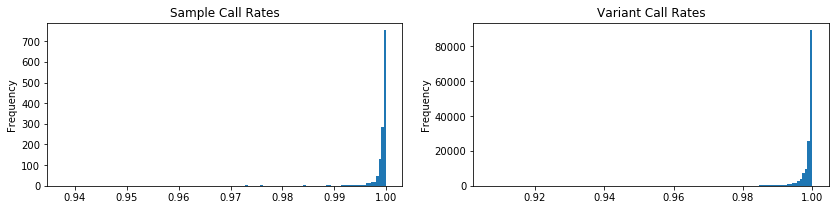

In [26]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((14, 3))
axs[0].set_title('Sample Call Rates')
axs[1].set_title('Variant Call Rates')
pd.Series(hl.sample_qc(mt).sample_qc.call_rate.collect()).plot(kind='hist', bins=128, ax=axs[0])
pd.Series(hl.variant_qc(mt).variant_qc.call_rate.collect()).plot(kind='hist', bins=128, ax=axs[1])

In [27]:
def qc(mt):
    mt = hl.variant_qc(mt)
    mt = mt.filter_rows(mt.variant_qc.call_rate >= .98)
    mt = hl.sample_qc(mt)
    mt = mt.filter_cols(mt.sample_qc.call_rate >= .98)
    return mt
mt_qc = qc(mt)
mt_qc.count()

2020-02-07 23:04:46 Hail: INFO: Coerced sorted dataset
2020-02-07 23:04:53 Hail: INFO: Coerced sorted dataset
2020-02-07 23:05:02 Hail: INFO: Coerced sorted dataset
2020-02-07 23:05:02 Hail: INFO: Coerced sorted dataset


(148651, 1337)

In [28]:
path_mt_ref_qc = '/tmp/mt_ref.mt'
mt_qc.write(path_mt_ref_qc, overwrite=True)

2020-02-07 23:05:25 Hail: INFO: Coerced sorted dataset
2020-02-07 23:05:50 Hail: INFO: Coerced sorted dataset
2020-02-07 23:05:57 Hail: INFO: Coerced sorted dataset
2020-02-07 23:06:37 Hail: INFO: wrote matrix table with 148651 rows and 1337 columns in 2 partitions to /tmp/mt_ref.mt


### Prepare Extra Breed Information

This is primarily useful for mapping breed abbreviations in sample ids to more descriptive names, but the sample counts on aggregated studies are also helpful to understand the overlap between this reference study and the target study.

In [245]:
df_ref_br = pd.read_excel(osp.join(data_dir_ref, '1-s2.0-S2211124717304564-mmc2.xlsx'), sheet_name=0)
df_ref_br = df_ref_br.rename(columns=lambda c: c.lower()).rename(columns={'abrev.': 'abbr'})
df_ref_br.head()

,breed,abbr,clade,samples,vayasse-1,hayward-2,mizzou-3,total,coo,bioproject
0,American Cocker Spaniel,ACKR,Spaniel,10.0,NaN,NaN,NaN,10.0,NaN,"GSE90441, GSE96736"
1,American Eskimo Dog,AESK,Nordic Spitz,NaN,NaN,6.0,NaN,6.0,NaN,NaN
2,Afghan Hound,AFGH,Mediterranean,10.0,NaN,NaN,NaN,10.0,NaN,GSE90441
3,American Hairless Terrier,AHRT,American Terrier,10.0,NaN,NaN,NaN,10.0,NaN,GSE96736
4,Airedale Terrier,AIRT,Terrier,3.0,NaN,NaN,NaN,3.0,NaN,GSE96736


In [246]:
df_ref_br[['vayasse-1', 'hayward-2', 'mizzou-3', 'samples', 'total']].fillna(0).sum(axis=0)

vayasse-1     420.0
hayward-2     459.0
mizzou-3        7.0
samples      2012.0
total        2865.0
dtype: float64

In [249]:
# Note the sparsity here, which is best ignored in downstream mappings
df_ref_br[['breed', 'abbr', 'clade']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 3 columns):
breed    173 non-null object
abbr     168 non-null object
clade    159 non-null object
dtypes: object(3)
memory usage: 4.2+ KB


In [248]:
path_df_ref_br = '/tmp/df_ref_br.csv'
df_ref_br[['breed', 'abbr', 'clade']].to_csv(path_df_ref_br, index=False)
path_df_ref_br

'/tmp/df_ref_br.csv'

In [275]:
def get_df_ref_br():
    return pd.read_csv(path_df_ref_br)

## Load Target Data

In [253]:
mt = hl.import_plink(
    osp.join(data_dir_tgt, plink_file_tgt + '.bed'),
    osp.join(data_dir_tgt, plink_file_tgt + '.bim'),
    osp.join(data_dir_tgt, plink_file_tgt + '.fam'),
    skip_invalid_loci=False, 
    reference_genome='canine'
)

2020-02-08 22:12:30 Hail: INFO: Found 4342 samples in fam file.
2020-02-08 22:12:30 Hail: INFO: Found 160727 variants in bim file.


In [254]:
mt.count()

2020-02-08 22:12:33 Hail: INFO: Coerced sorted dataset


(160727, 4342)

Call rates amongst this dataset are much higher, so only a few variants need to be removed:

In [255]:
pd.Series(hl.sample_qc(mt).sample_qc.call_rate.collect()).value_counts()

2020-02-08 22:12:41 Hail: INFO: Coerced sorted dataset
2020-02-08 22:12:51 Hail: INFO: Coerced sorted dataset
2020-02-08 22:12:51 Hail: INFO: Coerced sorted dataset


0.999988    4342
dtype: int64

In [256]:
pd.Series(hl.variant_qc(mt).variant_qc.call_rate.collect()).value_counts()

2020-02-08 22:12:52 Hail: INFO: Coerced sorted dataset


1.000000    160723
0.930677         2
0.069323         2
dtype: int64

In [257]:
mt_qc = qc(mt)
mt_qc.count()

2020-02-08 22:13:03 Hail: INFO: Coerced sorted dataset
2020-02-08 22:13:13 Hail: INFO: Coerced sorted dataset
2020-02-08 22:13:25 Hail: INFO: Coerced sorted dataset
2020-02-08 22:13:25 Hail: INFO: Coerced sorted dataset


(160723, 4342)

In [258]:
path_mt_tgt_qc = '/tmp/mt_tgt.mt'
mt_qc.write(path_mt_tgt_qc, overwrite=True)

2020-02-08 22:13:36 Hail: INFO: Coerced sorted dataset
2020-02-08 22:14:11 Hail: INFO: Coerced sorted dataset
2020-02-08 22:14:21 Hail: INFO: Coerced sorted dataset
2020-02-08 22:15:20 Hail: INFO: wrote matrix table with 160723 rows and 4342 columns in 6 partitions to /tmp/mt_tgt.mt


### Variant QC Sample Selection

In [259]:
def concat_prep(mt, source):
    mt = mt.annotate_cols(source=source)
    mt = mt.key_rows_by('locus')
    mt = mt.key_cols_by('source', 's')
    return mt
    
def concat_samples(mt_ref, mt_tgt, variants=None):
    mt_ref = concat_prep(mt_ref, 'ref')
    mt_tgt = concat_prep(mt_tgt, 'tgt')
    mt = mt_ref.union_cols(mt_tgt, row_join_type='inner')
    if variants is not None:
        mt = mt.semi_join_rows(variants)
    return mt

In [260]:
mt_tgt = hl.read_matrix_table(path_mt_tgt_qc).drop('sample_qc').drop('variant_qc')
mt_tgt.count()

(160723, 4342)

In [261]:
mt_ref = hl.read_matrix_table(path_mt_ref_qc).drop('sample_qc').drop('variant_qc')
mt_ref.count()

(148651, 1337)

##### Unpruned Population Projection

In [150]:
mt_mg = concat_samples(mt_ref, mt_tgt)

In [151]:
mt_mg.count()

2020-02-08 02:38:03 Hail: INFO: Coerced sorted dataset


(148362, 5679)

In [85]:
_, pcs, _ = hl.hwe_normalized_pca(mt_mg.GT, k=10, compute_loadings=False)
pcs.show(5, width=100)

2020-02-07 23:59:29 Hail: INFO: Coerced sorted dataset
2020-02-07 23:59:30 Hail: INFO: Coerced sorted dataset
2020-02-07 23:59:47 Hail: INFO: hwe_normalized_pca: running PCA using 148362 variants.
2020-02-07 23:59:48 Hail: INFO: Coerced sorted dataset
2020-02-07 23:59:48 Hail: INFO: Coerced sorted dataset
2020-02-08 00:00:09 Hail: INFO: pca: running PCA with 10 components...


source,s,scores
str,str,array<float64>
"""ref""","""ACKR_09007""","[-5.24e-02,-3.10e-02,7.69e-02,8.03e-02,-5.80e-02,7.22e-02,2.97e-02,-5.09e-02,-1.56e-01,-2.37e..."
"""ref""","""ACKR_09030""","[-4.18e-02,-3.60e-02,7.79e-02,7.67e-02,-5.14e-02,7.52e-02,3.01e-02,-4.57e-02,-1.62e-01,-2.94e..."
"""ref""","""ACKR_09032""","[-5.22e-02,-3.92e-02,7.62e-02,8.19e-02,-6.25e-02,9.03e-02,3.49e-02,-5.06e-02,-1.65e-01,-2.38e..."
"""ref""","""ACKR_09110""","[-4.88e-02,-4.63e-02,8.76e-02,7.17e-02,-6.01e-02,7.72e-02,2.83e-02,-4.64e-02,-1.59e-01,-1.45e..."
"""ref""","""ACKR_09991""","[-6.13e-02,-5.36e-02,8.54e-02,7.55e-02,-5.44e-02,7.53e-02,3.94e-02,-4.64e-02,-1.65e-01,-1.28e..."


In [88]:
def get_pca_data(mt, pcs):
    mt = mt.annotate_cols(scores = pcs[(mt.source, mt.s)].scores)
    return pd.DataFrame(hl.struct(s=mt.s, source=mt.source, PC1=mt.scores[0], PC2=mt.scores[1]).collect())
df_pca = get_pca_data(mt_mg, pcs)
df_pca.head()

2020-02-08 00:01:41 Hail: INFO: Coerced sorted dataset


,PC1,PC2,s,source
0,-0.036543,-0.101753,SALU_13122,ref
1,-0.042223,-0.094539,AZWK_15369,ref
2,-0.034696,-0.100854,SALU_22847,ref
3,-0.048662,-0.108461,SALU_22848,ref
4,-0.047838,-0.103081,AZWK_23339,ref


In [90]:
# Note: reference dataset has no useful phenotype designations (they are nearly all -9)
df_ref_fam = get_fam(data_dir_ref, plink_file_ref)
df_ref_fam.head()

,fid,iid,iid_paternal,iid_maternal,sex,pheno
0,SALU_CentAsia,SALU_13122,0,0,0,-9
1,AZWK_Mali,AZWK_15369,0,0,0,-9
2,SALU_CentAsia,SALU_22847,0,0,0,-9
3,SALU_CentAsia,SALU_22848,0,0,0,-9
4,AZWK_Mali,AZWK_23339,0,0,0,-9


Show breed counts:

In [280]:
def get_breed_from_fid(df, c):
    return df[c].str.split('[-_]').str[0]

In [281]:
get_breed_from_fid(df_ref_fam, 'fid').value_counts()

SALU    19
COOK    10
INCA    10
TIBS    10
SHIH    10
        ..
GWHP     2
CPAT     2
GDJK     2
KOMO     2
MNTY     2
Name: fid, Length: 166, dtype: int64

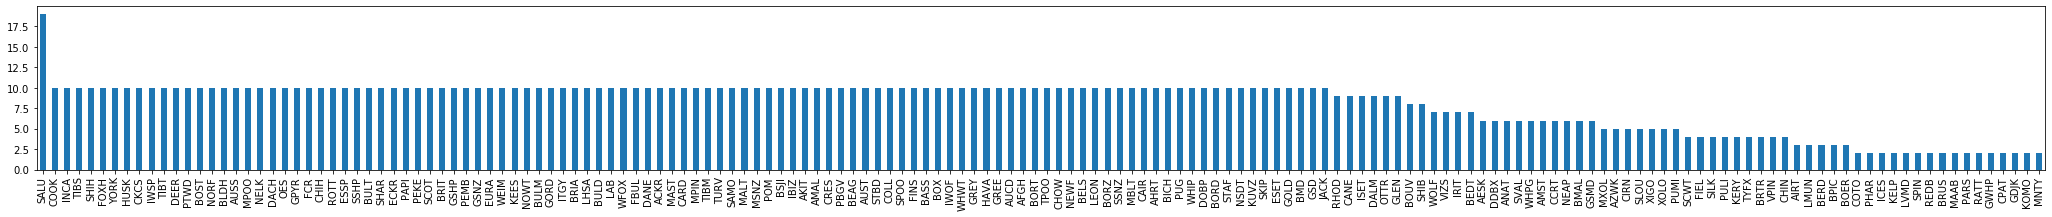

In [283]:
get_breed_from_fid(df_ref_fam, 'fid').value_counts().plot(kind='bar', figsize=(36, 3))

In [292]:
df_pca_ref_fam = pd.merge(
    df_pca,
    df_ref_fam.assign(breed=lambda df: get_breed_from_fid(df, 'fid')),    
    left_on='s',
    right_on='iid',
    how='left'
)  
# A few of the target sample ids match some reference dataset sample ids, but all have the fid "SKIP"
# df_pca_ref_fam.pipe(lambda df: df[df['source'] == 'tgt']).pipe(lambda df: df[df['breed'].notnull()])['iid'].unique()
# 'Sci_LU1455', 'Sci_LU1457', 'Sci_LU1458', 'Sci_LU1461', 'Sci_LU1464', 
# 'Sci_LU1466', 'Sci_LU1468', 'Sci_LU1471', 'Sci_LU1473'
# Override those breeds here:
df_pca_ref_fam = df_pca_ref_fam.assign(breed=lambda df: np.where(df['source'] == 'ref', df['breed'], None))

assert len(df_pca_ref_fam) == len(df_pca)
df_pca_ref_fam.head()

,PC1,PC2,s,source,fid,iid,iid_paternal,iid_maternal,sex,pheno,breed
0,-0.036543,-0.101753,SALU_13122,ref,SALU_CentAsia,SALU_13122,0.0,0.0,0.0,-9.0,SALU
1,-0.042223,-0.094539,AZWK_15369,ref,AZWK_Mali,AZWK_15369,0.0,0.0,0.0,-9.0,AZWK
2,-0.034696,-0.100854,SALU_22847,ref,SALU_CentAsia,SALU_22847,0.0,0.0,0.0,-9.0,SALU
3,-0.048662,-0.108461,SALU_22848,ref,SALU_CentAsia,SALU_22848,0.0,0.0,0.0,-9.0,SALU
4,-0.047838,-0.103081,AZWK_23339,ref,AZWK_Mali,AZWK_23339,0.0,0.0,0.0,-9.0,AZWK


Show PCA with unpruned variants where the larger target dataset is overlayed on the reference dataset with known breeds:

In [293]:
def get_pca_plot(df, title=None):
    traces = []
    for k, g in df.groupby(['source', 'breed']):
        marker = dict(size=6 if k[0] == 'ref' else 4)
        if k[0] == 'tgt':
            marker['color'] = 'grey'
        traces.append(go.Scatter(
            x=g['PC1'],
            y=g['PC2'],
            mode='markers',
            marker=marker,
            opacity=1 if k[0] == 'ref' else .2,
            name=k[1] if k[0] == 'ref' else ''
        ))
    layout = go.Layout(title=title)
    fig = go.Figure(data=traces, layout=layout)
    return fig

In [176]:
get_pca_plot(
    df_pca_ref_fam
    .assign(breed=lambda df: df['breed'].fillna('UNK'))
    .sort_values('source', ascending=False),
    title='PCA w/ All Shared Variants<br><i>Canine reference breeds overlaid with Hayward/Boyko (i.e. target) study samples</i>'
).show()

##### Pruned Popluation Projection

In [142]:
def get_pruned_variants(mt):
    # It would typically make sense here to try to filter to founders, 
    # but paternal/maternal ids are all 0s in both datasets
    return hl.ld_prune(mt.GT, r2=0.2, bp_window_size=500000)
ht_var = get_pruned_variants(mt_ref_pr.key_rows_by('locus', 'alleles'))

2020-02-08 02:29:36 Hail: INFO: ld_prune: running local pruning stage with max queue size of 174309 variants
2020-02-08 02:29:37 Hail: INFO: Coerced sorted dataset
2020-02-08 02:29:39 Hail: INFO: Coerced sorted dataset
2020-02-08 02:29:47 Hail: INFO: wrote table with 73610 rows in 2 partitions to file:/tmp/hail.pu9oozWyB82N/sfYBSDuXhh
2020-02-08 02:29:47 Hail: INFO: Coerced sorted dataset
2020-02-08 02:29:49 Hail: INFO: Coerced sorted dataset
2020-02-08 02:29:59 Hail: INFO: Wrote all 18 blocks of 73610 x 1337 matrix with block size 4096.
2020-02-08 02:31:04 Hail: INFO: wrote table with 1 row in 35 partitions to file:/tmp/hail.pu9oozWyB82N/YctfoSUcDk


In [180]:
mt_ref.count()

(148651, 1337)

In [144]:
ht_var.count()

73609

In [181]:
mt_mg_pr = concat_samples(mt_ref, mt_tgt, variants=ht_var.key_by('locus'))
mt_mg_pr.count()

2020-02-08 03:21:43 Hail: INFO: Coerced sorted dataset


(73609, 5679)

In [155]:
pcs_pr = hl.hwe_normalized_pca(mt_mg_pr.GT, k=10, compute_loadings=False)[1]
df_pca_ref_pr_fam = pd.merge(
    get_pca_data(mt_mg_pr, pcs_pr),
    get_fam(data_dir_ref, plink_file_ref).assign(breed=lambda df: df['fid'].str.split('[-_]').str[0]),
    left_on='s',
    right_on='iid',
    how='left'
)
df_pca_ref_pr_fam.head()

2020-02-08 02:46:59 Hail: INFO: Coerced sorted dataset
2020-02-08 02:47:16 Hail: INFO: hwe_normalized_pca: running PCA using 73609 variants.
2020-02-08 02:47:16 Hail: INFO: Coerced sorted dataset
2020-02-08 02:47:35 Hail: INFO: pca: running PCA with 10 components...
2020-02-08 02:48:22 Hail: INFO: Coerced sorted dataset


,PC1,PC2,s,source,fid,iid,iid_paternal,iid_maternal,sex,pheno,breed
0,-0.026017,-0.099577,SALU_13122,ref,SALU_CentAsia,SALU_13122,0.0,0.0,0.0,-9.0,SALU
1,-0.031705,-0.098073,AZWK_15369,ref,AZWK_Mali,AZWK_15369,0.0,0.0,0.0,-9.0,AZWK
2,-0.027278,-0.095341,SALU_22847,ref,SALU_CentAsia,SALU_22847,0.0,0.0,0.0,-9.0,SALU
3,-0.031853,-0.106580,SALU_22848,ref,SALU_CentAsia,SALU_22848,0.0,0.0,0.0,-9.0,SALU
4,-0.036770,-0.097706,AZWK_23339,ref,AZWK_Mali,AZWK_23339,0.0,0.0,0.0,-9.0,AZWK


A homogenous population must be selected -- UKBB docs:

> We also performed an exact test for Hardy-Weinberg equilibrium for each batch [9]. 
Again, selecting a homogeneous subset of samples makes the procedure more 
conservative, as Hardy-Weinberg equilibrium does not necessarily hold in the presence 
of population structure.

In [277]:
def get_df_ref_br_abbr_map(field='breed'):
    assert field in ['breed', 'clade']
    return get_df_ref_br()[['abbr', 'breed']].dropna().set_index('abbr')[field].to_dict()

In [312]:
br_map = get_df_ref_br_abbr_map()
fig = get_pca_plot(
    df_pca_ref_pr_fam
    .assign(breed=lambda df: df['breed'].fillna('UNK').apply(lambda v: '{} ({})'.format(br_map[v], v) if v in br_map else v))
    .sort_values('source', ascending=False),
    title='PCA w/ Pruned Variants<br><i>Canine reference breeds overlaid with Hayward/Boyko (i.e. target) study samples</i>'
)
populations = {
    'IWOF': {'name': 'Irish Wolfhound', 'bbox': dict(x0=-.08, x1=.02, y0=-.32, y1=-.23)},
    'LAB': {'name': 'Laborador Retriever', 'bbox': dict(x0=-.18, x1=-.05, y0=.25, y1=.55)},
    'BOX': {'name': 'Boxer', 'bbox': dict(x0=.88, x1=1.38, y0=.08, y1=.18)},
    'GOLD': {'name': 'Golden/Flat-Coated Retriever', 'bbox': dict(x0=-.09, x1=-.01, y0=.07, y1=.14)},
    'MIXED': {'name': 'Mixed', 'bbox': dict(x0=-.07, x1=.04, y0=-.09, y1=.03)},
}
for k, v in populations.items():
    b = v['bbox']
    fig.add_shape(go.layout.Shape(
        type="rect",
        x0=b['x0'], y0=b['y0'], x1=b['x1'], y1=b['y1'],
        line=dict(color="RoyalBlue"),
        opacity=.5
    ))
    fig.add_annotation(go.layout.Annotation(
        x=b['x0'] + (b['x1'] - b['x0']) / 2, y=b['y1'] + .02, xref="x", yref="y",
        text=v['name'], showarrow=False
    ))
fig.show()

In [314]:
# Create a function that will isolate a Hail dataset based on the population bounds shown above
def filter_target_samples(mt, pcs, bounds):
    mt = mt.annotate_cols(source='tgt').key_cols_by('source', 's')
    mt = mt.annotate_cols(scores=pcs[(mt.source, mt.s)].scores)
    mt = mt.annotate_cols(PC1=mt.scores[0], PC2=mt.scores[1])
    mt = mt.drop('scores')
    mt = mt.filter_cols(
        (mt.PC1 >= bounds['x0']) & (mt.PC1 <= bounds['x1']) & 
        (mt.PC2 >= bounds['y0']) & (mt.PC2 <= bounds['y1'])
    )
    return mt

## Variant QC

Perform HWE filtering on variants for only the populations selected above.

Based on [Hardy weinberg expectations in canine breeds: implications for genetic studies.](https://www.ncbi.nlm.nih.gov/pubmed/17526918), we should expect that HWE is observed within individual breeds, but not across a mixture of them.  This can be seen below where the smaller populations spanning a smaller portion of the population substructure (i.e. PCA) space have HWE p-value distributions with much higher density near zero, implying that the HWE null hypothesis cannot be rejected.  

For the "MIXED" population it is clear that the vast majority of variants are way out of HWE.  

The "LAB" (i.e. Laborador Retriever) population shows signs of being more mixed than the other "pure" populations, which may be an indication that some remaining population structure exists within this group (or perhaps there are sub-breeds of labs that aren't represented here).

In [322]:
%%time
# Filter the target dataset matrix table to appropriate samples for each population
pop_mt = {
    k: filter_target_samples(mt_tgt, pcs_pr, v['bbox'])
    for k, v in populations.items()
}

# Determine HWE p-values for each population
pop_hwep = {
    k: hl.variant_qc(mt).variant_qc.p_value_hwe.collect()
    for k, mt in pop_mt.items()
}

CPU times: user 1.04 s, sys: 3.47 ms, total: 1.04 s
Wall time: 20.5 s


In [386]:
def get_hwep_distribution_fig(pop_hwep, title=None):
    traces = []
    bins = np.linspace(-40, 0, num=32)
    for k, v in pop_hwep.items():
        p = np.clip(np.log10(np.array(v) + 1e-40), -40, 0)
        p = pd.cut(p, bins=bins).value_counts()
        x = ['{:.2f}'.format(i.right) for i in p.index]
        traces.append(go.Scatter(
            x=x,
            y=np.where(p.values == 0, np.nan, p.values),
            name=k,
            mode='markers+lines',
            opacity=1
        ))
    layout = go.Layout(
        yaxis_type='log', barmode='group', title=title, 
        xaxis=dict(title=r'$log_{10}(\text{HWE p-value})$'),
        yaxis=dict(title='Number of Variants')
    )
    return go.Figure(data=traces, layout=layout)

title = 'Variant HWE Distribution by Population'
fig = get_hwep_distribution_fig(pop_hwep, title=title)
fig.show()